In [1]:
import gzip         # for reading .pkl.gz
import pickle       # to load the pickled dicts
import numpy as np  # for arrays, math
import matplotlib.pyplot as plt  # for plotting
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap

In [2]:
def mesh_index_to_km(x):
    return (x / 299) * 110

def km_to_mesh_index(x):
    return (x / 110) * 299

Grounding Line plotting - Bedrock Erosion = 1.0 e -9

In [3]:
gl_run_title_be_1e9 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 1.00 E^-9")
be_1e9 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run1_be1E-9/DATA_Dictionary_2025_03_24__13_32_47.pkl.gz"
with gzip.open(be_1e9, 'rb') as f:
    DATA_dict_be_1e9 = pickle.load(f)

In [4]:
bed_dict = DATA_dict_be_1e9['bed_dict']
base_dict = DATA_dict_be_1e9['base_dict']
surf_dict= DATA_dict_be_1e9 ['surf_dict']
sed_dict = DATA_dict_be_1e9['sed_dict']
H_dict = DATA_dict_be_1e9['H_dict']
us_dict = DATA_dict_be_1e9['us_dict']
ub_dict = DATA_dict_be_1e9['ub_dict']
Hs_dict = DATA_dict_be_1e9['Hs_dict']
GL_dict = DATA_dict_be_1e9['GL_dict']
Qs_dict = DATA_dict_be_1e9['Qs_dict']

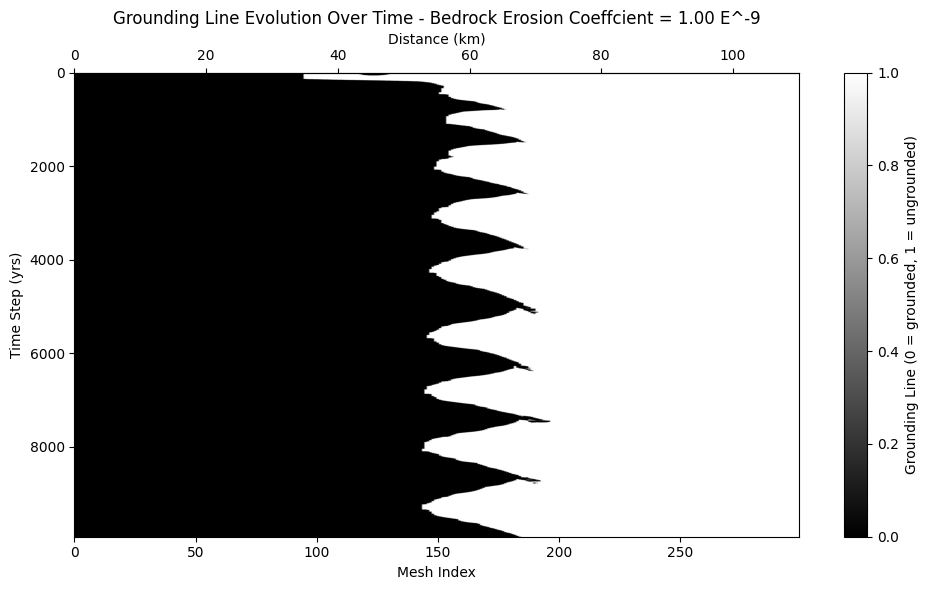

In [5]:
GL_dict = DATA_dict_be_1e9['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_1e9)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

Grounding Line plotting - Bedrock Erosion = 5.5 e -9


In [6]:
gl_run_title_be_55e9 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 5.5e-9")
be_55e9 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run2_be5.5E-9/DATA_Dictionary_2025_04_13__22_09_00.pkl.gz"
with gzip.open(be_55e9, 'rb') as f:
    DATA_dict_be_55e9 = pickle.load(f)

In [7]:
bed_dict = DATA_dict_be_55e9['bed_dict']
base_dict = DATA_dict_be_55e9['base_dict']
surf_dict= DATA_dict_be_55e9 ['surf_dict']
sed_dict = DATA_dict_be_55e9['sed_dict']
H_dict = DATA_dict_be_55e9['H_dict']
us_dict = DATA_dict_be_55e9['us_dict']
ub_dict = DATA_dict_be_55e9['ub_dict']
Hs_dict = DATA_dict_be_55e9['Hs_dict']
GL_dict = DATA_dict_be_55e9['GL_dict']
Qs_dict = DATA_dict_be_55e9['Qs_dict']

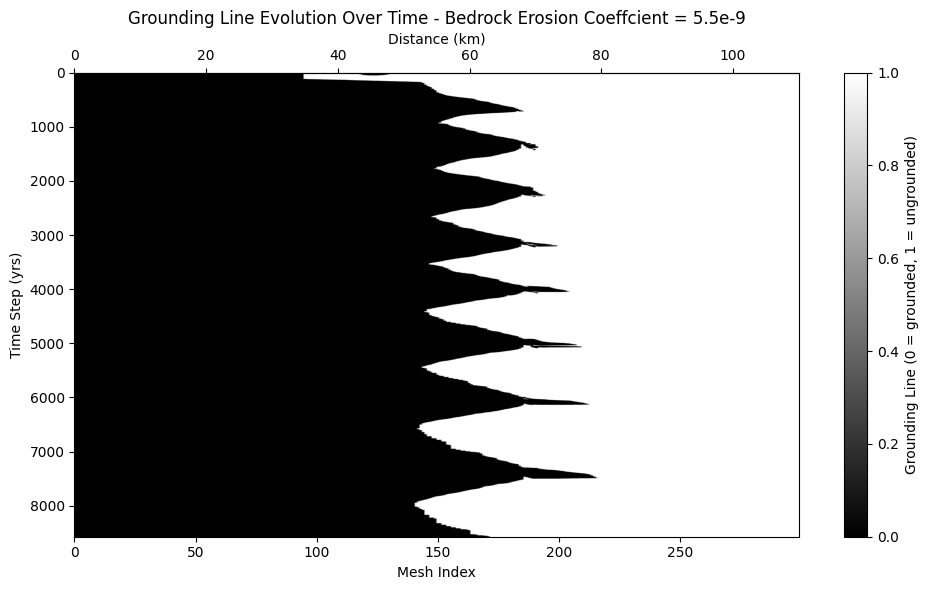

In [8]:
GL_dict = DATA_dict_be_55e9['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_55e9)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

Grounding Line plotting - Bedrock Erosion = 1.0 e -8

In [9]:
gl_run_title_be_1e8 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 1.00 E^-8")
be_1e8 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run3_be1E-8/DATA_Dictionary_2025_04_02__11_59_04.pkl.gz"
with gzip.open(be_1e8, 'rb') as f:
    DATA_dict_be_1e8 = pickle.load(f)

In [10]:
bed_dict = DATA_dict_be_1e8['bed_dict']
base_dict = DATA_dict_be_1e8['base_dict']
surf_dict= DATA_dict_be_1e8 ['surf_dict']
sed_dict = DATA_dict_be_1e8['sed_dict']
H_dict = DATA_dict_be_1e8['H_dict']
us_dict = DATA_dict_be_1e8['us_dict']
ub_dict = DATA_dict_be_1e8['ub_dict']
Hs_dict = DATA_dict_be_1e8['Hs_dict']
GL_dict = DATA_dict_be_1e8['GL_dict']
Qs_dict = DATA_dict_be_1e8['Qs_dict']

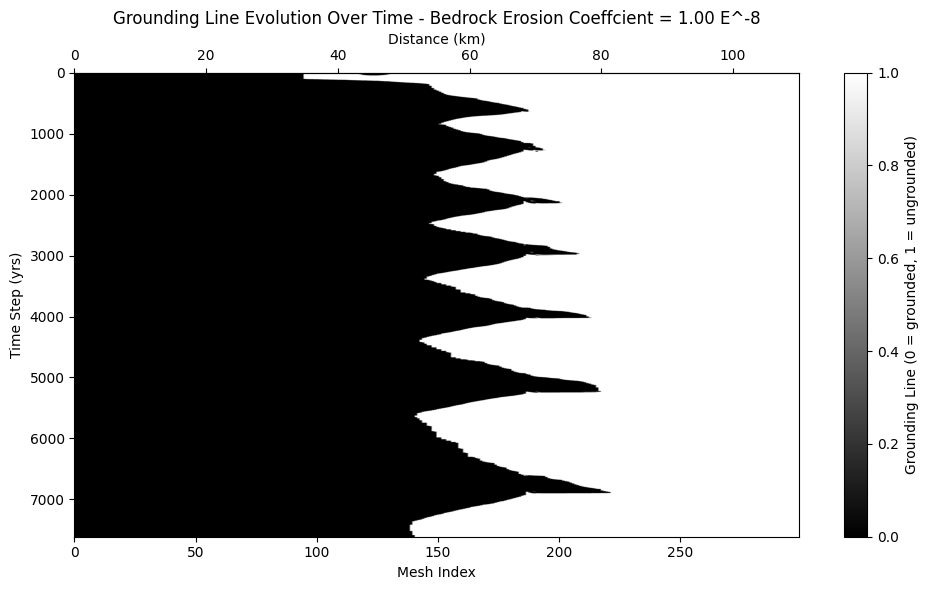

In [11]:
GL_dict = DATA_dict_be_1e8['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_1e8)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

Grounding Line plotting - Bedrock Erosion = 5.5 e -8

In [12]:
gl_run_title_be_55e8 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 5.5e-8")
be_55e8 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run4_5.5E-8/DATA_Dictionary_2025_04_13__23_47_23.pkl.gz"
with gzip.open(be_55e8, 'rb') as f:
    DATA_dict_be_55e8 = pickle.load(f)

In [13]:
bed_dict = DATA_dict_be_55e8['bed_dict']
base_dict = DATA_dict_be_55e8['base_dict']
surf_dict= DATA_dict_be_55e8 ['surf_dict']
sed_dict = DATA_dict_be_55e8['sed_dict']
H_dict = DATA_dict_be_55e8['H_dict']
us_dict = DATA_dict_be_55e8['us_dict']
ub_dict = DATA_dict_be_55e8['ub_dict']
Hs_dict = DATA_dict_be_55e8['Hs_dict']
GL_dict = DATA_dict_be_55e8['GL_dict']
Qs_dict = DATA_dict_be_55e8['Qs_dict']

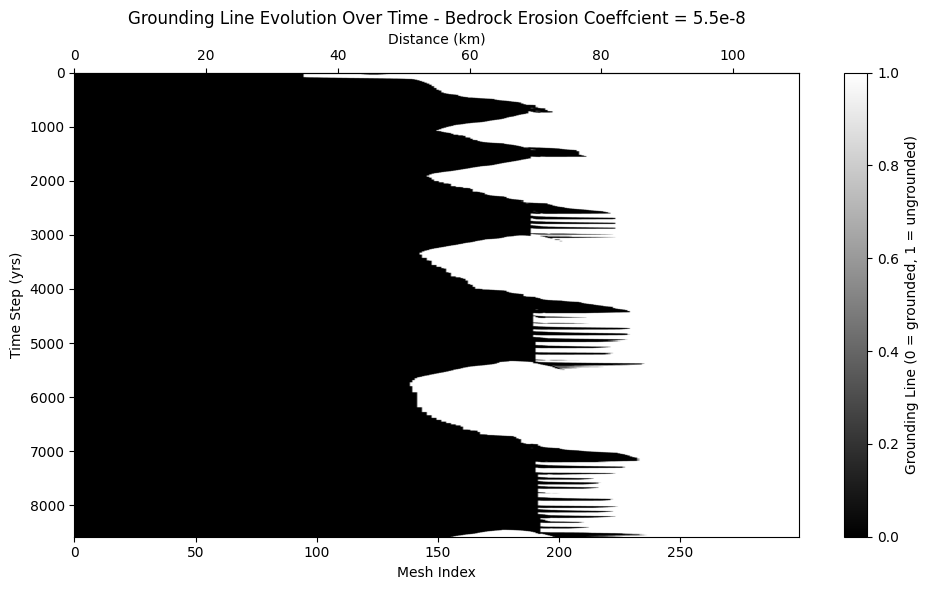

In [14]:
GL_dict = DATA_dict_be_55e8['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_55e8)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

Grounding Line plotting - Bedrock Erosion = 1.0 e -7

In [15]:
gl_run_title_be_1e7 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 1.00 E^-7")
be_1e7 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/beTests/Run5_be1E-7/DATA_Dictionary_2025_03_24__14_53_22.pkl.gz"
with gzip.open(be_1e7, 'rb') as f:
    DATA_dict_be_1e7 = pickle.load(f)

In [16]:
bed_dict = DATA_dict_be_1e7['bed_dict']
base_dict = DATA_dict_be_1e7['base_dict']
surf_dict= DATA_dict_be_1e7 ['surf_dict']
sed_dict = DATA_dict_be_1e7['sed_dict']
H_dict = DATA_dict_be_1e7['H_dict']
us_dict = DATA_dict_be_1e7['us_dict']
ub_dict = DATA_dict_be_1e7['ub_dict']
Hs_dict = DATA_dict_be_1e7['Hs_dict']
GL_dict = DATA_dict_be_1e7['GL_dict']
Qs_dict = DATA_dict_be_1e7['Qs_dict']

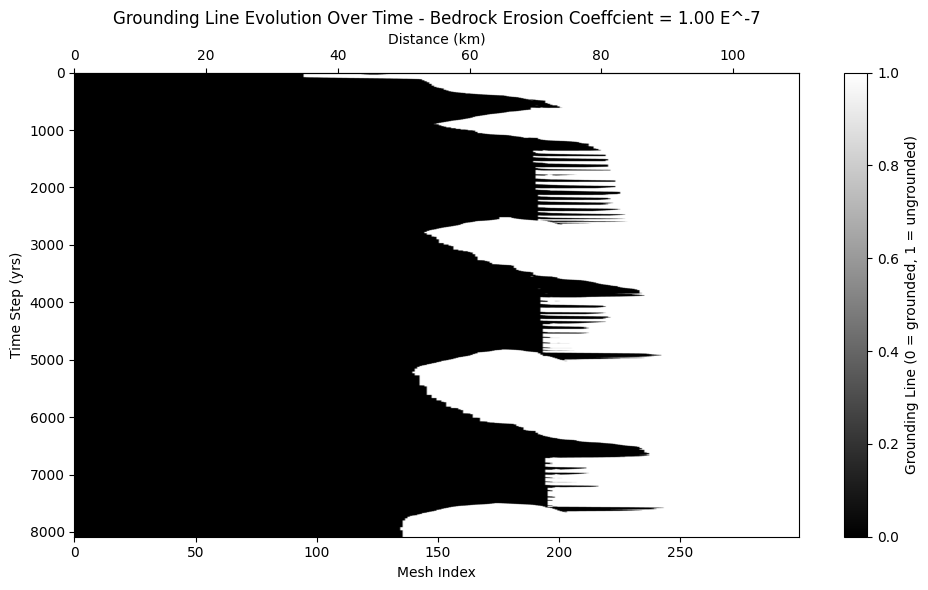

In [17]:
GL_dict = DATA_dict_be_1e7['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_1e7)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [18]:
## Bedrock Erosion ##
title_BE_cycles = str("Number of Cycles Produced  VS Bedrock Erosion")
BEs = np.array([1e-9, 5.5e-9, 1e-8, 5.5e-8, 1e-7])
BE_cycles = np.array([8, 8, 7, 5, 4])
BE_coeff = np.polyfit(BEs,BE_cycles, 1)
p_BE = np.poly1d(BE_coeff)
BE_y_trend = p_BE(BEs)
R_2_BE =r2_score(BE_cycles,p_BE(BEs))


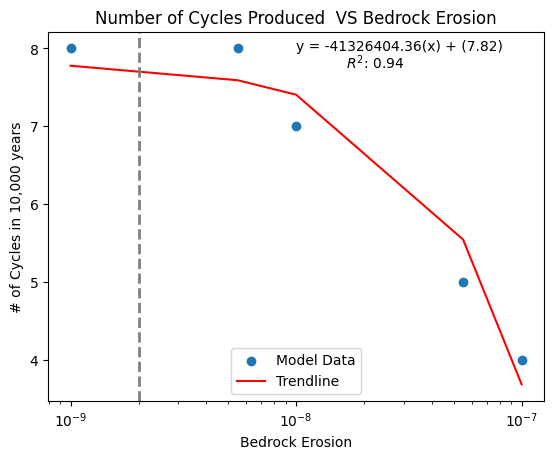

In [19]:
plt.scatter(BEs, BE_cycles, label = 'Model Data')
plt.title(title_BE_cycles)
plt.plot(BEs, BE_y_trend, color='red', label='Trendline')
plt.text(0.6, 0.9, f'$R^2$: {R_2_BE:.2f}', transform=plt.gca().transAxes)
plt.text(0.5, 0.95, f'y = {BE_coeff[0]:.2f}(x) + ({BE_coeff[1]:.2f})', transform=plt.gca().transAxes)
plt.axvline(x=2e-9, color='gray', linestyle='--', linewidth=2)
plt.xlabel("Bedrock Erosion")
plt.xscale('log')
plt.ylabel("# of Cycles in 10,000 years")
plt.legend()
# plt.xticks(np.arange(1e-9, 1e-8, 1e-9)) 
